# Earhquake Location Estimation using Social Media Data

Due to the speed of post creations and ease of near realtime access, using social media such as Twitter can be a potential for gaining situational awareness following disasters.

# First part: using Twitter
First getting some data.
There are several ways to do this. Here I use `tweepy`

In [1]:
import tweepy
from tweepy import OAuthHandler
import json
import datetime as dt
import time
import os
import sys
import json
import pandas as pd


# puting my tweeter API info
consumer_key = " "
consumer_secret = " "
access_token = " "
access_secret = " "
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

Twitter limits the maximum number of tweets returned per search to 100. 
`tweet_search()` function searches for up to max_tweets=100 tweets. 
Whenever it reached the max_tweets limit, it will pause for 15 minuts and then resume the search.

`get_tweet_id()` function finds the ID of a tweet that was posted at the end of a given day.

In [3]:
def get_tweet_id(api, date='', days_ago=9, query='a'):
    ''' Function that gets the ID of a tweet. This ID can then be
        used as a 'starting point' from which to search. The query is
        required and has been set to a commonly used word by default.
        The variable 'days_ago' has been initialized to the maximum
        amount we are able to search back in time (9).'''

    if date:
        # return an ID from the start of the given day
        td = date + dt.timedelta(days=1)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        tweet = api.search(q=query, count=1, until=tweet_date)
    else:
        # return an ID from __ days ago
        td = dt.datetime.now() - dt.timedelta(days=days_ago)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        # get list of up to 10 tweets
        tweet = api.search(q=query, count=10, until=tweet_date)
        print('search limit (start/stop):',tweet[0].created_at)
        # return the id of the first tweet in the list
        return tweet[0].id

def tweet_search(api, query, max_tweets, max_id, since_id, geocode):
    ''' Function that takes in a search string 'query', the maximum
        number of tweets 'max_tweets', and the minimum (i.e., starting)
        tweet id. It returns a list of tweepy.models.Status objects. '''

    searched_tweets = []
    while len(searched_tweets) < max_tweets:
        remaining_tweets = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q=query, count=remaining_tweets,
                                    since_id=str(since_id),
                                    max_id=str(max_id-1))
            print('found',len(new_tweets),'tweets')
            if not new_tweets:
                print('no tweets found')
                break
            searched_tweets.extend(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError:
            print('exception raised, waiting 15 minutes')
            print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
            time.sleep(15*60)
            break # stop the loop
    return searched_tweets, max_id


def write_tweets(tweets, filename):
    ''' Function that appends tweets to a file. '''

    with open(filename, 'a') as f:
        for tweet in tweets:
            json.dump(tweet._json, f)
            f.write('\n')

now searching for keywords (the word earthquake in 23 languages) in past 1 week and saving the results in json.

In [4]:
def main():
    ''' This is a script that continuously searches for tweets
        that were created over a given number of days. The search
        dates and search phrase can be changed below. '''

    ''' search variables: '''
    search_phrases = ['earthquake', 'sismo', 
                     'quake', 'temblor',
                     'terremoto', 'tremblement',
                     'erdbeben', 'deprem',
                     'σεισμός', 'seismós',
                     'séisme', 'zemljotres',
                     'potres', 'terremot',
                     'jordskjelv', 'cutremur',
                     'aardbeving', '地震',
                     'भूकंप', 'زلزال', 
                     'tremor', '지진', 'زلزله' ] 
               
    time_limit = 0.001                           # runtime limit in hours
    max_tweets = 100                           # number of tweets per search (will be
                                               # iterated over) - maximum is 100
    min_days_old, max_days_old = 1, 8          # search limits e.g., from 7 to 8
                                               # gives current weekday from last week,   

    USA = '39.8,-95.583068847656,2500km'
    # loop over search items,
    # creating a new file for each
    for search_phrase in search_phrases:

        print('Search phrase =', search_phrase)

        ''' other variables '''
        name = search_phrase.split()[0]
        json_file_root = name + '/'  + name
        os.makedirs(os.path.dirname(json_file_root), exist_ok=True)
        read_IDs = False
        
        # open a file in which to store the tweets
        if max_days_old - min_days_old == 1:
            d = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}'.format(d.year, d.month, d.day)
        else:
            d1 = dt.datetime.now() - dt.timedelta(days=max_days_old-1)
            d2 = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}_to_{3}-{4:0>2}-{5:0>2}'.format(
                  d1.year, d1.month, d1.day, d2.year, d2.month, d2.day)
        json_file = json_file_root + '_' + day + '.json'
        if os.path.isfile(json_file):
            print('Appending tweets to file named: ',json_file)
            read_IDs = True
        
        # authorize and load the twitter API
        api = tweepy.API(auth)
        
        # set the 'starting point' ID for tweet collection
        if read_IDs:
            # open the json file and get the latest tweet ID
            with open(json_file, 'r') as f:
                lines = f.readlines()
                max_id = json.loads(lines[-1])['id']
                print('Searching from the bottom ID in file')
        else:
            # get the ID of a tweet that is min_days_old
            if min_days_old == 0:
                max_id = -1
            else:
                max_id = get_tweet_id(api, days_ago=(min_days_old-1))
        # set the smallest ID to search for
        since_id = get_tweet_id(api, days_ago=(max_days_old-1))
        print('max id (starting point) =', max_id)
        print('since id (ending point) =', since_id)
        

        ''' tweet gathering loop  '''
        start = dt.datetime.now()
        end = start + dt.timedelta(hours=time_limit)
        count, exitcount = 0, 0
        while dt.datetime.now() < end:
            count += 1
            print('count =',count)
            # collect tweets and update max_id
            tweets, max_id = tweet_search(api, search_phrase, max_tweets,
                                          max_id=max_id, since_id=since_id,
                                          geocode=USA)
            # write tweets to file in JSON format
            if tweets:
                write_tweets(tweets, json_file)
                exitcount = 0
            else:
                exitcount += 1
                if exitcount == 3:
                    if search_phrase == search_phrases[-1]:
                        sys.exit('Maximum number of empty tweet strings reached - exiting')
                    else:
                        print('Maximum number of empty tweet strings reached - breaking')
                        break


if __name__ == "__main__":
    main()
    

Search phrase = earthquake
search limit (start/stop): 2018-09-14 23:59:59
search limit (start/stop): 2018-09-07 23:59:59
max id (starting point) = 1040752051607797761
since id (ending point) = 1038215336535965697
count = 1
found 92 tweets
found 3 tweets
found 4 tweets
found 1 tweets
count = 2
found 100 tweets
count = 3
found 100 tweets
count = 4
found 100 tweets
count = 5
found 100 tweets
count = 6
found 100 tweets
count = 7
found 100 tweets
Search phrase = sismo
search limit (start/stop): 2018-09-14 23:59:59
search limit (start/stop): 2018-09-07 23:59:59
max id (starting point) = 1040752051607797761
since id (ending point) = 1038215336535965697
count = 1
found 90 tweets
found 10 tweets
count = 2
found 98 tweets
found 2 tweets
count = 3
found 97 tweets
found 3 tweets
count = 4
found 100 tweets
count = 5
found 100 tweets
count = 6
found 100 tweets
count = 7
found 100 tweets
count = 8
found 98 tweets
found 1 tweets
found 1 tweets
count = 9
found 100 tweets
Search phrase = quake
search li

found 100 tweets
count = 2
found 100 tweets
count = 3
found 100 tweets
count = 4
found 56 tweets
found 0 tweets
no tweets found
count = 5
found 0 tweets
no tweets found
count = 6
found 0 tweets
no tweets found
count = 7
found 0 tweets
no tweets found
Maximum number of empty tweet strings reached - breaking
Search phrase = 地震
search limit (start/stop): 2018-09-14 23:59:59
search limit (start/stop): 2018-09-07 23:59:59
max id (starting point) = 1040752051607797761
since id (ending point) = 1038215336535965697
count = 1
found 95 tweets
found 5 tweets
count = 2
found 100 tweets
count = 3
found 93 tweets
found 3 tweets
found 2 tweets
found 0 tweets
no tweets found
count = 4
found 97 tweets
found 3 tweets
count = 5
found 99 tweets
found 0 tweets
no tweets found
count = 6
found 90 tweets
found 8 tweets
found 2 tweets
count = 7
found 86 tweets
found 11 tweets
found 2 tweets
found 0 tweets
no tweets found
Search phrase = भूकंप
search limit (start/stop): 2018-09-14 23:59:59
search limit (start/s

# now reading and analyzing the downloaded data

In [5]:
tweet_files = ['./data/tweets/earthquake_2018-09-04_to_2018-09-10.json']
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

If we plot the text of first 10 tweets

In [6]:
for t in tweets[:10]:
    print(t['text'])

RT @ChrChristensen: International Media on #SwedenElection
6 months ago: Earthquake as Far-Right Party Poised to Become Largest Party in Sw…
RT @GSI_chiriin: 【地殻変動情報】だいち2号のSARデータを使用した解析による、 #平成30年北海道胆振東部地震 に伴う地殻変動分布図を公開しました。
今後も地殻変動の監視を続けていきます。
詳細はこちら→https://t.co/vDFA0hYtOd http…
RT @GSI_chiriin: 【地殻変動情報】だいち2号のSARデータを使用した解析による、 #平成30年北海道胆振東部地震 に伴う地殻変動分布図を公開しました。
今後も地殻変動の監視を続けていきます。
詳細はこちら→https://t.co/vDFA0hYtOd http…
RT @LastQuake: #Earthquake (#deprem) possibly felt 2 min ago in #Antalya #Turkey. Felt it? See https://t.co/wPtMW5ND1t https://t.co/I2qCjqz…
RT @LastQuake: M5.2 #earthquake (#gempa) strikes 62 km NE of #Mataram (#Indonesia) 21 min ago. Updated map of its effects: https://t.co/Zaa…
RiskLogic Japan Series | Part Two Available Now

At 2.46 pm on March 2011, Japan was subjected to an enormous earth… https://t.co/NZiuxOgpQ8
RT @LoveeSie: Can’t nobody tell me shit when I be shaking my ass my lil booty can cause an earthquake 🤪😭
@bogey174 @Goldengal301 @BRNRGAL Oh those are ter

Our goal is to detect earthquakes based on evidences of firsthand felt reports from Twitter. So we need to identify tweets originating from users who experienced earthquake shaking like this one:

![the tweets we are looking for](F.png)

To minimize such contamination with the twitter activities following the release of news or blog articles, we remove all tweets that contain Uniform Resource Locators (URLs), specifically the
string “http”. 

Furthermore, we remove all tweets with the text “RT” or “@”. “RT” is commonly used to identify a tweet 
as a rebroadcast or “retweet” of another users tweet and the “@” symbol is used in front of a username to reply to another user’s tweet. 
Thus tweets containing “@” and “RT” are likely to arise from a user commenting on an earthquake from outside the felt area.

Filtering tweets with these keywords out, we archive the tweet creation time, text, and coordinates into a dataframe.

In [7]:
text = []
time = []
long = []
lat = []
tid = []

for t in tweets:    
    if not ('RT' or '@' or 'http' or 'https://') in t['text']:
        if t['coordinates'] != None:
            
            text.append(t['text'])
            time.append(t['created_at'])
            long.append(t['coordinates']['coordinates'][0])
            lat.append(t['coordinates']['coordinates'][1])
            tid.append(t['id'])

dd = {'time':time, 'text':text, 'longitude':long, 'latitude':lat , 'id': tid}

df = pd.DataFrame(dd)

df.time = pd.to_datetime(df.time)

#df.set_index('time', inplace=True)

df.head()

,time,text,longitude,latitude,id
0,2018-09-10 23:52:54,"【微小地震速報】\n2018/09/11 8:41:21 JST, \nアメリカ合衆国 カリ...",-116.8212,33.25083,1039300715460476930
1,2018-09-10 23:51:54,"【小地震速報】\n2018/09/11 8:37:12 JST, \nアメリカ合衆国 アラス...",-144.4390,69.56800,1039300464435638272
2,2018-09-10 23:49:54,"【微小地震速報】\n2018/09/11 8:22:00 JST, \nニュージーランド ウ...",173.1669,-41.66373,1039299961018507265
3,2018-09-10 23:47:54,"【小地震速報】\n2018/09/11 8:14:11 JST, \nアメリカ合衆国 アラス...",-146.4700,69.29000,1039299456905109504
4,2018-09-10 23:46:54,"【小地震速報】\n2018/09/11 8:02:56 JST, \nトルコ アンタリヤの北...",30.6500,37.22000,1039299205209055235


Now lets get the earthquake data for the same time period. 
Again there are several ways for doing this using fancy APIs. But I do it in the easiest way, using Us Geological Survey's web service. 
Simply generate something like this:

`http://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2000-01-01%2000:00:00&endtime=2015-1231%2023:59:59&maxlatitude=50&minlatitude=24.6&maxlongitude=-65&minlongitude=-125&minmagnitude=3&eventtype=earthquake&orderby=time-asc`

In [10]:
from pathlib import Path
from copy import copy
import requests

BASE_ENDPOINT = 'http://earthquake.usgs.gov/fdsnws/event/1/query.csv'
BASE_PARAMS = {
    'eventtype'   : 'earthquake',
    'orderby'     : 'time-asc',
    'starttime'   : '2018-09-04 00:00:00',
    'endtime'     : '2018-09-11 00:00:00',
    'minmagnitude': 3,
    'maxlatitude' : 90,
    'minlatitude' : -90,
    'maxlongitude': 180,
    'minlongitude': -180 }

DATA_DIR = Path('data', 'usgs')
DATA_DIR.mkdir(exist_ok=True, parents=True)

print("Contacting", BASE_ENDPOINT)

resp = requests.get(BASE_ENDPOINT, params=BASE_PARAMS)
print("Received response", resp.status_code)
print('from:', resp.url)

if resp.status_code == 200:
    fname = DATA_DIR.joinpath('us-earthquakes-{yra}-{yrb}.csv'.format(yra=2018, yrb=2018))
    with fname.open('w') as wf:
        print("Saving:", fname)
        wf.write(resp.text)
else:
    print("Error", resp.url)
    print(resp.text)
    
eqs = pd.DataFrame.from_csv('./data/usgs/us-earthquakes-2018-2018.csv')
eqs.head()

Contacting http://earthquake.usgs.gov/fdsnws/event/1/query.csv
Received response 200
from: https://earthquake.usgs.gov/fdsnws/event/1/query.csv?eventtype=earthquake&orderby=time-asc&starttime=2018-09-04+00%3A00%3A00&endtime=2018-09-11+00%3A00%3A00&minmagnitude=3&maxlatitude=90&minlatitude=-90&maxlongitude=180&minlongitude=-180
Saving: data/usgs/us-earthquakes-2018-2018.csv


/Users/mostafamousavi/anaconda3/envs/obspy/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
time,,,,,,,,,,,,,,,,,,,,,
2018-09-04 00:20:07.950,-39.8100,-71.6819,139.97,4.8,mb,NaN,46.0,0.277,0.94,us,...,2018-09-04T02:00:36.103Z,"48km NW of San Martin de los Andes, Argentina",earthquake,6.8,4.5,0.057,94.0,reviewed,us,us
2018-09-04 00:42:40.402,56.9622,-153.0047,16.10,3.0,ml,NaN,NaN,NaN,0.59,ak,...,2018-09-11T16:57:54.022Z,"87km SE of Larsen Bay, Alaska",earthquake,NaN,0.5,NaN,NaN,automatic,ak,ak
2018-09-04 02:51:30.420,39.5584,76.6279,35.90,4.4,mb,NaN,98.0,1.928,0.76,us,...,2018-09-04T03:01:12.040Z,"45km ESE of Arzak, China",earthquake,7.3,7.3,0.131,17.0,reviewed,us,us
2018-09-04 03:48:23.356,69.1255,-147.9447,0.00,3.0,ml,NaN,NaN,NaN,0.81,ak,...,2018-09-11T16:57:56.319Z,"126km S of Prudhoe Bay, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
2018-09-04 04:46:57.650,-5.5405,147.1335,202.35,4.7,mb,NaN,120.0,3.481,0.51,us,...,2018-09-04T04:59:19.040Z,"131km N of Lae, Papua New Guinea",earthquake,11.8,20.9,0.167,11.0,reviewed,us,us


And now plotting the earthquakes

/Users/mostafamousavi/anaconda3/envs/obspy/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'time' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


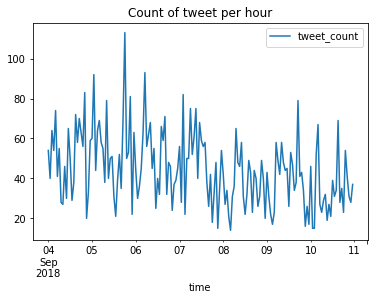

In [11]:
df2 = df[["longitude","latitude","time"]].groupby("time").agg({"time":"count"}).sort_values("time",ascending = False).rename(columns={'time':'tweet_count'})

df2.resample("h").sum().plot(title = "Count of tweet per hour")


/Users/mostafamousavi/anaconda3/envs/obspy/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'updated' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


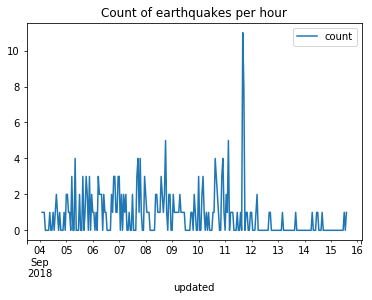

In [12]:
df3 = eqs[["longitude","latitude", "updated"]].groupby("updated").agg({"updated":"count"}).sort_values("updated",ascending = False).rename(columns={"updated":'count'})
df3.index = pd.to_datetime(df3.index)

df3.resample("h").sum().plot(title = "Count of earthquakes per hour")

plt.show()

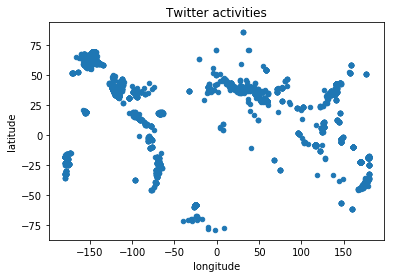

In [13]:
df.plot(x='longitude', y='latitude', kind = 'scatter')
plt.title('Twitter activities')
plt.show()

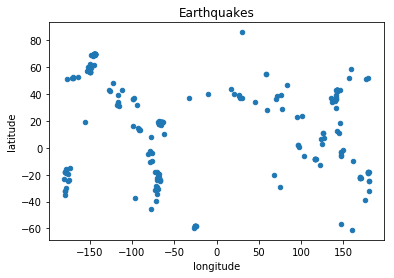

In [14]:
eqs.plot(x='longitude', y='latitude', kind = 'scatter')
plt.title('Earthquakes')
plt.show()

Now lets see the temporal-spacial destribution of Twitter activities

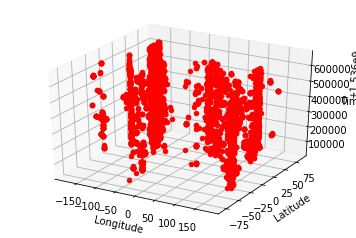

In [15]:
import time
from datetime import date

centers = []
for i in range(len(df.longitude)):   
    centers.append([df.loc[i]['longitude'], df.loc[i]['latitude'], int(df.loc[i]['time'].strftime('%s'))])

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(df.longitude)): 
    ax.scatter(centers[i][0], centers[i][1], centers[i][2], c='r', marker='o')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')
plt.show()

# Clustering

I use affinity propagation (Frey and Dueck, 2007) for the clustering. 
This method is based on the concept of "message passing" between data points and finds "examplars" of the input set that are representative of clusters.

![affinity propagation](F5.png)

AP simultaneously considers all data points as potential exemplars. Considering each data point as a node in
a network, this method recursively transmits real-valued messages (similarity measurements) along edges of the network until a good set of exemplars and corresponding clusters emerges.

I use this algorithem because unlike other clustering algorithms such as k-means, affinity propagation does not require the number of clusters to be determined or estimated before running the algorithm. 

Brendan J. Frey and Delbert Dueck (2007) “Clustering by Passing Messages Between Data Points”, Science.

In [16]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

X, labels_true = make_blobs(n_samples=len(centers), centers=centers, cluster_std=0.2,
                            random_state=0)

# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

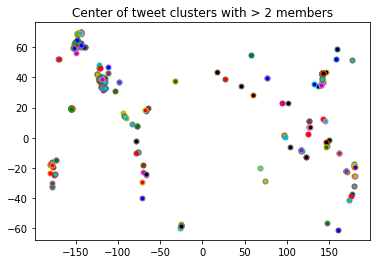

In [22]:
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

clusC = []
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    
    
    if len(X[class_members, 0]) > 2:
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markersize=5)
        clusC.append([cluster_center[0], cluster_center[1]])

plt.title('Center of tweet clusters with > 2 members')
plt.show()

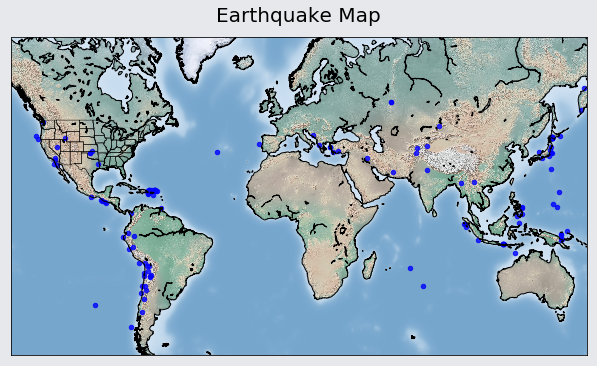

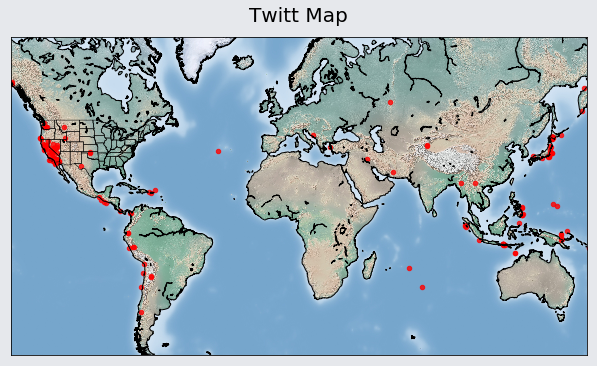

In [37]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

my_map = Basemap(llcrnrlon=-140, llcrnrlat=-55,
        urcrnrlon=160, urcrnrlat=70,
        resolution='l', projection='merc', lat_0 = 50, lon_0 = -100)  

fig1 = plt.figure(figsize=(10,12))
fig1.patch.set_facecolor('#e6e8ec')
ax = fig1.add_axes([0.1,0.1,0.8,0.8])

my_map.drawcoastlines()
my_map.shadedrelief()
my_map.readshapefile('st99_d00', name='states', drawbounds=True)
 
# add coordinates as red dots
title = plt.title('Earthquake Map', fontsize=20) 
title.set_y(1.03) # Move the title a bit for niceness
 
longs = list(eqs.longitude)
latts = list(eqs.latitude)

x, y = my_map(longs, latts)

my_map.scatter(x, y, s=20, c= 'b', marker = 'o', alpha = 0.8)

plt.show()

my_map = Basemap(llcrnrlon=-140, llcrnrlat=-55,
        urcrnrlon=160, urcrnrlat=70,
        resolution='l', projection='merc', lat_0 = 50, lon_0 = -100)  

fig2 = plt.figure(figsize=(10,12))
fig2.patch.set_facecolor('#e6e8ec')
ax = fig2.add_axes([0.1,0.1,0.8,0.8])

my_map.drawcoastlines()
my_map.shadedrelief()
my_map.readshapefile('st99_d00', name='states', drawbounds=True)

title = plt.title('Twitt Map', fontsize=20) 
title.set_y(1.03) # Move the title a bit for niceness

lon = []
lat = []

for i in range(len(clusC)):
    lon.append(clusC[i][0])
    lat.append(clusC[i][1])
      
x1, y1 = my_map(lon, lat)

my_map.scatter(x1, y1, s=20, c= 'r', marker = 'o', alpha = 0.8)

plt.show()


As you can see from above plots we got fairly close without using any NLP or training data set. 